In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats.stats import pearsonr
import scipy.optimize as optimize
import math
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn import linear_model
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn import neighbors
import seaborn as sns
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score, r2_score

df_tran = pd.read_csv('./dataset/tran.txt',names=['primary-date','time','approximate-indicator','secondary-date','approximate-indicator',
  'transaction-ID','player','type','from-team','from-league','to-team','to-league','draft-type','draft-round','pick-number','info'])
df_playerid = pd.read_csv('./dataset/playerid_list.csv',names=['LASTNAME','FIRSTNAME','PLAYERID','DAVENPORTCODE','MLBCODE','player'],skiprows=1);
df_master = pd.read_csv('./dataset/Master.csv')
df_batting = pd.read_csv('./dataset/Batting.csv')
df_pitching = pd.read_csv('./dataset/Pitching.csv')
df_fielding = pd.read_csv('./dataset/Fielding.csv')
df_batstat = pd.read_csv('./dataset/war_daily_bat.txt')
df_pitchstat = pd.read_csv('./dataset/war_daily_pitch.txt')
df_cpi = pd.read_csv('./dataset/CPI.csv')
df_salaries = pd.read_csv('./dataset/Salaries.csv')
pd.set_option('display.max_columns', 60)
df_teams = pd.read_csv('./dataset/Teams.csv')

# Data Cleanup
# Recontructing invalid dates
df_tran['primary-date'] = df_tran['primary-date'].astype('str')
df_tran['primary-date'] = df_tran['primary-date'].str.replace(r'\A(\d{4})[0]{4}', r'\g<1>0101')
df_tran['primary-date'] = df_tran['primary-date'].str.replace(r'\A(\d{4})(..)[0]{2}', r'\g<1>\g<2>01')

#Extracting only trades from transaction dataframe
df_tran = df_tran[df_tran['type'] == "T "]
df_tran = df_tran[df_tran['to-league'].isin(['AL','NL'])]
df_tran = df_tran[df_tran['from-league'].isin(['AL','NL'])]

df_tran['primary-date'] = pd.to_datetime(df_tran['primary-date'], format='%Y%m%d')
df_tran['tranYear'] = df_tran['primary-date'].apply(lambda x : int(x.year))

/usr/local/lib/python3.4/dist-packages/IPython/core/interactiveshell.py:2705: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Advanced Model

In [10]:
df_master['player_ID'] = df_master['bbrefID']
df_batstat = pd.merge(df_batstat,df_master[['player_ID','retroID']],on='player_ID',how='inner')
df_pitchstat = pd.merge(df_batstat,df_master[['player_ID','retroID']],on='player_ID',how='inner')
df_batting = pd.merge(df_batting,df_master[['playerID','retroID','birthYear']],on='playerID')
df_pitching = pd.merge(df_pitching,df_master[['playerID','retroID','birthYear']],on='playerID')
df_fielding = pd.merge(df_fielding,df_master[['playerID','retroID','birthYear']],on='playerID')
df_batting['age']= df_batting['yearID'] - df_batting['birthYear']
df_pitching['age']= df_pitching['yearID'] - df_pitching['birthYear']
df_fielding['age']= df_fielding['yearID'] - df_fielding['birthYear']

In [11]:
df_batstat_sort = df_batstat.sort('age')
df_batstat_sort = df_batstat_sort[pd.notnull(df_batstat_sort['age'])]
agedict = {}

#print df_batstat_sort.age
for index, row in df_batstat_sort.iterrows():
    if(row['age'] in agedict):
        agedict[row['age']].append(row['WAR'])
    else:
        agedict[row['age']] = [row['WAR']]

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [12]:
age = []
avg_WAR= []
i=0
for key in agedict:
    if (~np.isnan(key)):
        avg = np.nansum(agedict[key]) / float(len(agedict[key]))
        age.append(key)
        avg_WAR.append(avg)
        
age_df = pd.DataFrame({ 'Age' : age,'Average_WAR' : avg_WAR}).sort('Age')

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [13]:
#age_df
def getAvgWarForAge(age):
    return (age_df[(age_df['Age'] == age)]['Average_WAR']).iloc[0]

In [ ]:
plt.xlabel("Age")
plt.ylabel("Average_WAR")
plt.plot(age_df.Age, age_df.Average_WAR);

In [14]:
def player_performance_projection(playerID, age):
    player_df = df_batstat[(df_batstat['retroID'] == playerID)]
    player_df_before = player_df[player_df['age']< age]
    diff = [0]
    for index,row in player_df_before.iterrows():
        diff.append(row['WAR'] - getAvgWarForAge(row['age']))
    mPerf  = np.mean(diff)    
    dict = {}
    for j in range(1,16):
        if age + j < 50:
            dict[j] = (getAvgWarForAge(age + j) + mPerf/j)
        else:
            dict[j] = 0
    return dict

In [15]:
def trade_value_year_projection(tranID,metric):
    td = df_tran[(df_tran['transaction-ID'] == tranID)]
    teams = td['from-team'].unique()
    val = 0
    player_vals = []
    for x in teams:
        valDict = {}
        for index, row in td.iterrows():
            val = 0
            if (row['from-team'] == x):
                if pd.isnull(row['player']):
                    # filter out cash transactions or yet to be named player transaction
                    continue
                birthYear = df_master['birthYear'][df_master['retroID'] == row['player']]
                if birthYear.empty:
                    continue
                birthYear = birthYear.iloc[0]
                age = row['tranYear'] - birthYear
                tempDict = player_performance_projection(row['player'],age)
                for i in range(1,16):
                    if i in valDict.keys():
                        valDict[i] += tempDict[i]
                    else:
                        valDict[i] = tempDict[i]
        player_vals.append(valDict)
    return player_vals

In [16]:
def f(c):
    ret = 0.0
    for key, value in dict1.items():
        ret  += pow((1 - c[0]/100),key)*value
    for key, value in dict2.items():
        ret  -= pow((1 - c[1]/100),key)*value
    return abs(ret)

bnds = ((0, 100), (0, 100))

In [ ]:
trade_val_projection_list = []
transactions = df_tran['transaction-ID'].unique()
for x in transactions:
    listnew = trade_value_year_projection(x,'WAR')
    dict1 = listnew[0]
    dict2 = listnew[1]
    result = optimize.minimize(f, (50, 50), method='TNC', bounds=bnds)
    trade_val_projection_list.append((x,result.x,result.fun))

In [17]:
def trade_value_year_actual(tranID,metric):
    td = df_tran[(df_tran['transaction-ID'] == tranID)]
    teams = td['from-team'].unique()
    val = 0
    player_vals = []
    for x in teams:
        valDict = {}
        for index, row in td.iterrows():
            val = 0
            if (row['from-team'] == x):
                if pd.isnull(row['player']):
                    # filter out cash transactions or yet to be named player transaction
                    continue
                player_df = df_batstat[(df_batstat['retroID'] == row['player'])]
                player_df_year = player_df[(player_df['year_ID'] == row['tranYear'])]
                #instead need a df for the player after the trans year, and not just next, but all consecutive years
                for i in range(1,15):
                    player_df_year_next = player_df[(player_df['year_ID'] == (row['tranYear'] + i))]
                    if not player_df_year_next.empty:
                        # get the value of metric for each year after trade until 15 years else assume 0
                        t = float(player_df_year_next[metric].iloc[0])
                        #print(t)
                        if i in valDict.keys():
                            valDict[i] += t
                        else:
                            valDict[i] = t
                    else:
                        ## figure out a way to find war for these players
                        if i in valDict.keys():
                            valDict[i] += 0
                        else:
                            valDict[i] = 0
        player_vals.append(valDict)
    return player_vals

In [ ]:
def f2(c,dict_1,dict_2):
    ret = 0.0
    for key, value in dict_1.items():
        ret  += pow((1 - c[0]/100),key)*value
    for key, value in dict_2.items():
        ret  -= pow((1 - c[1]/100),key)*value
    return abs(ret)

diff_list = [] 
for i in trade_val_projection_list:
    listnew = trade_value_year_actual(i[0],'WAR') #should come from projections instead of actual value
    act = f2( i[1], listnew[0], listnew[1])
    diff_list.append((i[0],act))

In [ ]:
import pickle
with open('diff_list.pkl', 'wb') as f:
    pickle.dump(diff_list,f)

In [18]:
import pickle
with open("diff_list.pkl", "rb") as input_file:
    diff_list = pickle.load(input_file)

In [19]:
sList = sorted(diff_list,key=lambda x: x[1], reverse=True)

In [20]:
rank_df = pd.DataFrame(columns = ['Rank','Date','Team1','Team2','Players Team1','Player Team2','Trade Value Diff'])
k = 0
for i in sList:
    tranID = i[0]
    tran = df_tran[df_tran['transaction-ID'] == tranID]
    teams = tran['from-team'].unique()
    t1 = teams[0]
    t2 = teams[1]
    p1List = []
    p2List = []
    for index,row in tran.iterrows():
        pl = df_master[df_master['retroID'] == row['player']]
        if row['from-team'] == t1:
            p1List.append(''.join(pl['nameFirst'].values +" "+ pl['nameLast'].values))
        else:
            p2List.append(''.join(pl['nameFirst'].values + " " + pl['nameLast'].values))
    p1str = ','.join(p1List)
    p2str = ','.join(p2List)
    date = tran['primary-date'].iloc[0]
    rank_df.loc[k] = [int(k+1),date,t1,t2,p1str,p2str,i[1]]
    k += 1

In [7]:
rank_df['tranMonth'] = rank_df['Date'].apply(lambda x : int(x.month))
rank_df['tranYear'] = rank_df['Date'].apply(lambda x : int(x.year))

In [93]:
merged_column = rank_df[['tranYear','Trade Value Diff']].dropna()
print(pearsonr(merged_column['tranYear'], merged_column['Trade Value Diff']))

(-0.18193798395574406, 4.8448540273174716e-43)


In [27]:
curr_cpi = df_cpi[df_cpi['Year']==2016]['CPI'].iloc[0]
df_sort = df_tran.sort(['transaction-ID'])
no_of_trade = pd.DataFrame(columns = ['Year','PIT', 'SL5', 'CHN', 'WS8', 'IN3', 'PHI', 'NY1', 'LS3', 'SLN',
       'BLN', 'BSN', 'BRO', 'WSN', 'CL4', 'CIN', 'CLE', 'BOS', 'DET',
       'WS1', 'CHA', 'NYA', 'SLA', 'PHA', 'MLN', 'BAL', 'KC1', 'SFN',
       'LAN', 'WS2', 'LAA', 'MIN', 'HOU', 'NYN', 'CAL', 'ATL', 'OAK',
       'SDN', 'KCA', 'MON', 'SE1', 'MIL', 'TEX', 'TOR', 'SEA', 'FLO',
       'COL', 'ANA', 'ARI', 'TBA', 'WAS', 'MIA'] )
#no_of_trade = no_of_trade.set_index(['Year'])
#no_of_trade=no_of_trade.fillna(0.0, inplace=True)
td = df_sort['transaction-ID'].unique()
year = df_sort['tranYear'].unique()
no_of_trade['Year'] = year
no_of_trade=no_of_trade.fillna(0)
for x in range(0, len(td)):
    tran_id = df_sort[df_sort['transaction-ID']==td[x]].iloc[0]
    yr = no_of_trade[no_of_trade['Year'] == tran_id['tranYear']].iloc[0]
    yr[tran_id['from-team']] = yr[tran_id['from-team']] + 1;
    no_of_trade[tran_id['from-team']][no_of_trade['Year'] == tran_id['tranYear']] = yr[tran_id['from-team']]
    yr[tran_id['to-team']] = yr[tran_id['to-team']] + 1;
    no_of_trade[tran_id['to-team']][no_of_trade['Year'] == tran_id['tranYear']] = yr[tran_id['to-team']]
    
tdiffDict = {}
for i in sList:
    tdiffDict[i[0]] = i[1]

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


In [37]:
#Calculates various params for each trade
def trade_value_old(tranID,metric):
    td = df_tran[(df_tran['transaction-ID'] == tranID)]
    teams = td['from-team'].unique()
    val = 0
    year = td['tranYear'].iloc[0]
    player_vals = [] #To calculate player val diff
    num_players = [] #To calculate diff of number of players involved
    num_trades = [] #To calculate number of trades each side players were involved in before the trade
    num_trades_team = [] #To calculate number of trades each team did in this year
    ages = [] #Average ages of the two sides
    ranks = []
    salary_vals = []
    for x in teams:
        #print x
        val = 0 #for player_vals[]
        num = 0 #for num_players[]
        age = 0 #for ages[]
        num_tr = 0 # for num_trades[]
        sal = 0
        t_ranks = df_teams[(df_teams['teamIDretro'] == x)]
        t_rank = t_ranks[(t_ranks['yearID'] == year)]
        if not t_rank.empty:
            rank = t_rank['Rank'].iloc[0]
        else:
            rank = 7
            
        num_tr_team = no_of_trade[x][no_of_trade['Year']==year].iloc[0]
        
        for index, row in td.iterrows():
            if (row['from-team'] == x):
                if pd.isnull(row['player']):
                    # filter out cash transactions or yet to be named player transaction 
                    continue
                num += 1
                #year = int(row['tranYear'])
                player_df = df_batstat[(df_batstat['retroID'] == row['player'])]
                player_df_year = player_df[(df_batstat['year_ID'] == row['tranYear'])]
                
                trades = df_tran[(df_tran['player'] == row['player'])]
                trades_before = trades[(trades['tranYear'] < row['tranYear'])]
                num_tr += len(trades_before)
                
                if not player_df_year.empty:
                    val += float(player_df_year[metric].iloc[0])
                    age += player_df_year['age'].iloc[0]
                    slp = player_df_year['salary'].iloc[0]
                    if not math.isnan(slp):
                        sal += slp
                elif not player_df.empty:
                    # take a random value if we don't have war for that transaction year
                    val += float(player_df[metric].iloc[0])
                    age += player_df['age'].iloc[0]
                    slp = float(player_df['salary'].iloc[0])
                    if not math.isnan(slp):
                        sal += slp
                else:
                    ## figure out a way to find war for these players
                    val += 0
        num_players.append(num)
        num_trades.append(num_tr)
        num_trades_team.append(num_tr_team)
        player_vals.append(val)
        ranks.append(rank)
        salary_vals.append(sal)
        if(num==0):
            num = 1
        ages.append(float(age/num))
        v_diff = tdiffDict[tranID]
    sal_diff = abs(salary_vals[0]-salary_vals[1])
    new_val = sal_diff
    old_cpi_df = df_cpi[df_cpi['Year']== year]['CPI']
    old_cpi = old_cpi_df.iloc[0]
    try:
        new_sal_diff = int(float((curr_cpi/old_cpi))*float(sal_diff))
    except ValueError as e:
        new_sal_diff = sal_diff
    #return (abs(player_vals[0]-player_vals[1]),tranID,abs(num_players[0]-num_players[1]),year,abs(ages[0]-ages[1]),v_diff)
    resultDict = {}
    resultDict['TranID'] = tranID
    resultDict['Year'] = year
    resultDict['Team_1'] = teams[0]
    resultDict['Team_2'] = teams[1]
    resultDict['Trade_Value_Diff'] = v_diff
    resultDict['WAR_Sum_1'] =  player_vals[0]
    resultDict['WAR_Sum_2'] = player_vals[1]
    resultDict['Num_Players_1'] = num_players[0]
    resultDict['Num_Players_2'] = num_players[1]
    resultDict['Ages_1'] = ages[0]
    resultDict['Ages_2'] = ages[1]
    resultDict['Num_Player_Trades_1'] = num_trades[0]
    resultDict['Num_Player_Trades_2'] = num_trades[1]
    resultDict['Rank_1'] = ranks[0]
    resultDict['Rank_2'] = ranks[1]
    resultDict['Num_Trades_Team_1'] = num_trades_team[0]
    resultDict['Num_Trades_Team_2'] = num_trades_team[1]
    resultDict['Salary_Diff'] = new_sal_diff
    return resultDict

In [38]:
trade_val_list_WAR_old = []
transactions = df_tran['transaction-ID'].unique()
for x in transactions:
    trade_val_list_WAR_old.append(trade_value_old(x,'WAR'))

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [40]:
df_features = pd.DataFrame(trade_val_list_WAR_old, columns=["TranID","Year","Team_1","Team_2","Trade_Value_Diff","WAR_Sum_1",
                                                            "WAR_Sum_2","Num_Players_1","Num_Players_2","Ages_1","Ages_2",
                                                            "Num_Player_Trades_1","Num_Player_Trades_2","Rank_1","Rank_2","Num_Trades_Team_1",
                                                            "Num_Trades_Team_2","Salary_Diff"])

In [43]:
df_features.head()

,TranID,Year,Team_1,Team_2,Trade_Value_Diff,WAR_Sum_1,WAR_Sum_2,Num_Players_1,Num_Players_2,Ages_1,Ages_2,Num_Player_Trades_1,Num_Player_Trades_2,Rank_1,Rank_2,Num_Trades_Team_1,Num_Trades_Team_2,Salary_Diff
2360,50918,1979,CIN,CHN,0.016873,0.01,-0.14,1,1,27.0,28.0,1,0,1,5,4,8,0
577,49064,1940,WS1,BOS,1.005365,1.23,-0.50,1,1,32.0,34.0,2,1,7,4,3,5,8547
1399,49958,1966,ATL,CIN,0.013871,-0.28,-0.02,1,1,26.0,30.0,0,1,5,7,13,3,125486
940,49485,1956,KC1,NYA,0.108715,-0.05,0.65,2,2,32.5,29.5,1,4,8,1,7,4,0
2474,51032,1981,SEA,ATL,0.599867,-0.03,-0.30,1,1,24.0,30.0,0,1,6,5,7,3,88250


In [44]:
df_features['Num_Player_Diff'] = abs(df_features['Num_Players_1'] - df_features['Num_Players_2'])
df_features['Age_Diff'] = abs(df_features['Ages_1'] - df_features['Ages_2'])
df_features['WAR_Diff'] = abs(df_features['WAR_Sum_1'] - df_features['WAR_Sum_2'])

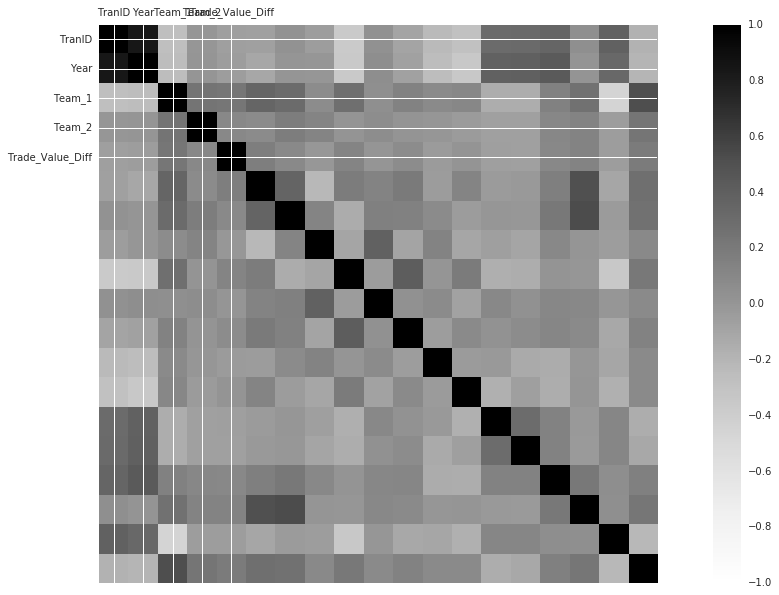

In [46]:
cols = df_features.columns
correlations = df_features[cols].corr(method='spearman')

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,5,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(cols)
ax.set_yticklabels(cols)
plt.show()

In [42]:
df_features = df_features.sample(frac=1)

In [47]:
inputV = df_features[["Num_Player_Diff","Year","Age_Diff","WAR_Diff","Salary_Diff"]]

In [48]:
clfList = [LinearRegression(),linear_model.Ridge(alpha = 0.5),Lasso(),DecisionTreeRegressor(max_depth=7),RandomForestRegressor(max_depth=10),neighbors.KNeighborsRegressor(n_neighbors=100)]

In [49]:
allRowsList = []
for idx,row in inputV.iterrows():
    currentRowList = row.values.tolist()
    allRowsList.append(currentRowList)

In [50]:

def calculate_error(actualValue, predictedValue):
    plt.xticks(range(-7,7,1))
    diff = (actualValue - predictedValue)
    ax = sns.distplot(diff, bins=50, label='Error in trade value diff')
    meanError = np.mean(diff)
    #print "Mean Error is", meanError
    stdError = np.std(diff)
    line1_string = 'Mean'
    line2_string = 'Std Dev'
    #ax.set_ylim((0,1))
    ax.set_xlim((-7,7))   
    ax.set_title('Probablity Distribution of Error')
    ax1 = ax.plot([meanError,meanError],[0,0.5])
    pos1 = [0,0.45]
    pos2 = [1,0.4]
    pos3 = [-1,0.4]
    ax.text(pos1[0], pos1[1], line1_string, size=9, color = 'b', ha="center", va="center")
    ax2 = ax.plot([stdError,stdError],[0,0.5], color='r')
    ax.text(pos2[0], pos2[1], line2_string, size=9, color = 'b', ha="center", va="center")
    ax3 = ax.plot([-stdError,-stdError],[0,0.5], color='r')
    ax.text(pos3[0], pos3[1], line2_string, size=9, color = 'b', ha="center", va="center")
    ax.set_xlabel('Error in trade value diff')
    ax.set_ylabel('Probability')
    plt.show()
    rms = sqrt(mean_squared_error(actualValue, predictedValue))
    print('Root mean square error:', rms)
    
    r2score = r2_score(actualValue, predictedValue)
    print('r2 score:', r2score)
    
    evs = explained_variance_score(actualValue, predictedValue)
    print('Explained variance score',evs)
    
    mae = mean_absolute_error(actualValue,predictedValue)
    print('Mean absolute error:',mae)


 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)


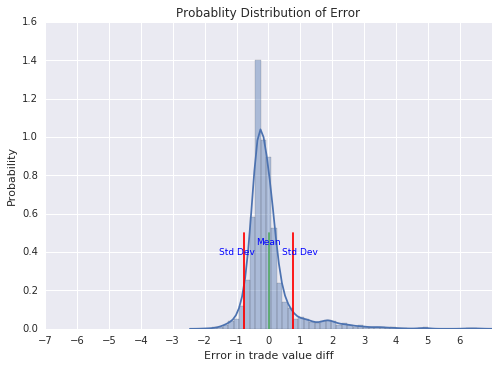

Root mean square error: 0.7613771744071922
r2 score: 0.240874349951
Explained variance score 0.240949742432
Mean absolute error: 0.456887807039

 Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)


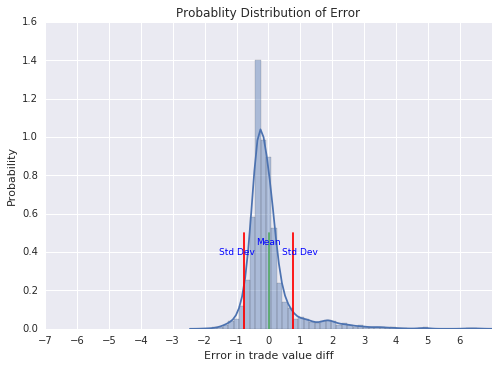

Root mean square error: 0.7613791206541748
r2 score: 0.240870468963
Explained variance score 0.240945854296
Mean absolute error: 0.456888294962

 Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)


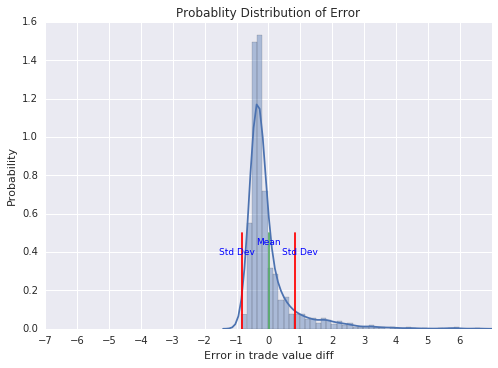

Root mean square error: 0.8340020407370181
r2 score: 0.0891472223368
Explained variance score 0.0891764789842
Mean absolute error: 0.513651432747

 DecisionTreeRegressor(criterion='mse', max_depth=7, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')


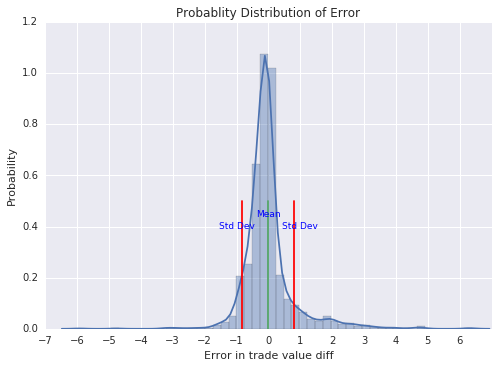

Root mean square error: 0.8142664426596196
r2 score: 0.131745516374
Explained variance score 0.131757796339
Mean absolute error: 0.45537840295

 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)


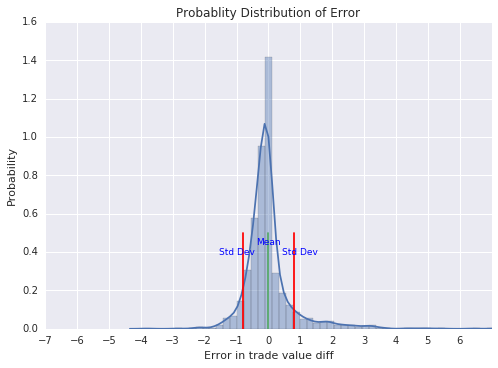

Root mean square error: 0.7918229876495017
r2 score: 0.178948929119
Explained variance score 0.178951730449
Mean absolute error: 0.449396269762

 KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=100, p=2,
          weights='uniform')


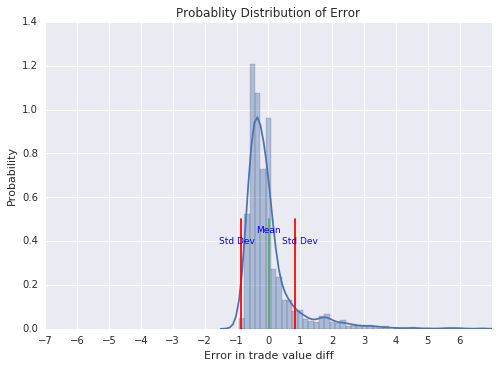

Root mean square error: 0.847965763045155
r2 score: 0.0583910105883
Explained variance score 0.0585872936432
Mean absolute error: 0.512615531496


In [57]:
from sklearn.metrics import f1_score
for i in clfList:
    clf = i.fit(allRowsList[:3963],df_features['Trade_Value_Diff'][:3963] )
    print("\n",i)
    predicted = clf.predict(allRowsList[3963:])
    calculate_error(df_features['Trade_Value_Diff'][3963:], predicted)

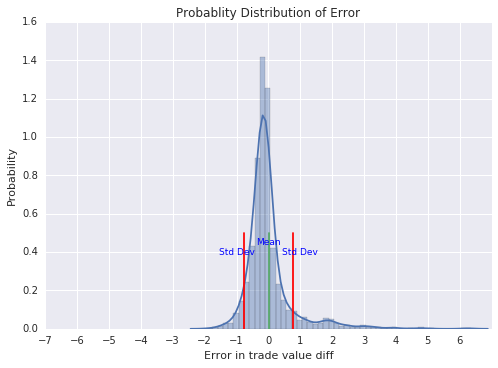

Root mean square error: 0.7573531962070396
r2 score: 0.248877302787
Explained variance score 0.248931829427
Mean absolute error: 0.439916231576


In [55]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
poly = PolynomialFeatures(degree=2)
X_ = poly.fit_transform(allRowsList[:3963])
predict_ = poly.fit_transform(allRowsList[3963:])

clf = linear_model.LinearRegression()
clf.fit(X_, df_features['Trade_Value_Diff'][:3963])
pred = clf.predict(predict_)
calculate_error(df_features['Trade_Value_Diff'][3963:], pred)